In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
from openparticle import ParticleOperator
import numpy as np
import cirq
from src.lobe.system import System
from src.lobe.block_encoding import add_lobe_oracle
from cirq.contrib.svg import SVGCircuit
from src.lobe.usp import add_naive_usp
from src.lobe._utils import get_basis_of_full_system
import openparticle as op
import copy

# Define Hamiltonian

In [50]:
bosonic_hamiltonian = (
    ParticleOperator("a0", 1) + 
    ParticleOperator("a1", 1) +
    ParticleOperator("a0^ a1", 1) +
    ParticleOperator("a1^ a0", 1)
    # ParticleOperator("a0^", 1) +
    # ParticleOperator("a1^", 1)
)
terms = bosonic_hamiltonian.to_list()

maximum_occupation_number = 3
number_of_modes = max([mode for term in terms for mode in term.modes]) + 1

full_fock_basis = get_basis_of_full_system(number_of_modes, maximum_occupation_number, has_bosons=True)
matrix = op.generate_matrix_from_basis(bosonic_hamiltonian, full_fock_basis)

eigenvalues, eigenvectors = np.linalg.eig(matrix)
print(sorted(eigenvalues.round(3)))

[(-3.464+0j), (-3-0j), (-3+0j), (-2+0j), (-1+0j), (-1-0j), 0j, (-0+0j), 0j, 0j, (1+0j), (1-0j), (2+0j), (3-0j), (3+0j), (3.464+0j)]


# Rescale Hamiltonian

In [51]:
max_coeff = max([term.coeff for term in terms])

max_number_of_bosonic_ops_in_term = 2
rescaled_terms = []
scaling_factor = (
    max_coeff
    * ((maximum_occupation_number + 1) ** (max_number_of_bosonic_ops_in_term / 2))
)

for term in copy.deepcopy(terms):
    # number_of_bosonic_ops = len(term.split())
    # if number_of_bosonic_ops > max_number_of_bosonic_ops_in_term:
    #     max_number_of_bosonic_ops_in_term = number_of_bosonic_ops
    # scale = max_coeff * ((maximum_occupation_number + 1) ** (number_of_bosonic_ops / 2))
    # scaling_factor = scale

    term.coeff /= scaling_factor
    rescaled_terms.append(term)


rescaled_hamiltonian = rescaled_terms[0]
for term in rescaled_terms[1:]:
    rescaled_hamiltonian += term


rescaled_matrix = op.generate_matrix_from_basis(rescaled_hamiltonian, full_fock_basis)

assert np.allclose(rescaled_matrix * scaling_factor, matrix)

rescaled_eigenvalues, rescaled_eigenvectors = np.linalg.eig(rescaled_matrix)

print(sorted(rescaled_eigenvalues.round(3)))
print(sorted((rescaled_eigenvalues * scaling_factor).round(3)))

for i in range(len(eigenvalues)):
    for j in range(len(rescaled_eigenvalues)):
        if np.abs(np.dot(rescaled_eigenvectors[:, j].T.conj(), eigenvectors[:, i]))**2 == 1:
            assert np.isclose(eigenvalues[i], rescaled_eigenvalues[j] * scaling_factor)
            assert np.allclose(rescaled_eigenvectors[:, j], eigenvectors[:, i])

[(-0.866+0j), (-0.75-0j), (-0.75+0j), (-0.5+0j), (-0.25+0j), (-0.25-0j), 0j, (-0+0j), 0j, 0j, (0.25+0j), (0.25-0j), (0.5+0j), (0.75-0j), (0.75+0j), (0.866+0j)]
[(-3.464+0j), (-3-0j), (-3+0j), (-2+0j), (-1+0j), (-1-0j), 0j, (-0+0j), 0j, 0j, (1+0j), (1-0j), (2+0j), (3-0j), (3+0j), (3.464+0j)]


# Generate LOBE Circuit

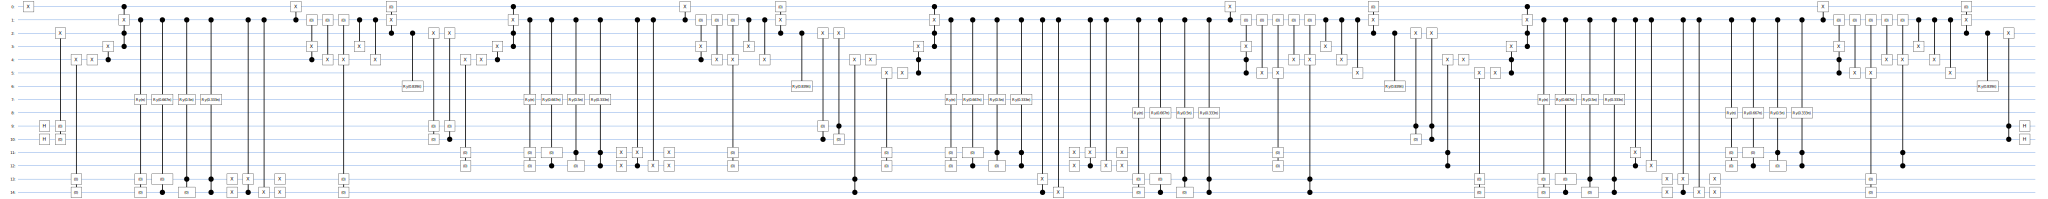

In [53]:
number_of_ancillae = 5
number_of_index_qubits = max(int(np.ceil(np.log2(len(terms)))), 1)
number_of_rotation_qubits = max_number_of_bosonic_ops_in_term + 1

# Declare Qubits
circuit = cirq.Circuit()
validation = cirq.LineQubit(0)
clean_ancillae = [cirq.LineQubit(i + 1) for i in range(number_of_ancillae)]
rotation_qubits = [
    cirq.LineQubit(i + 1 + number_of_ancillae)
    for i in range(number_of_rotation_qubits)
]
# rotation_qubits = [None] + rotation_qubits
index_register = [
    cirq.LineQubit(i + 1 + number_of_ancillae + 3)
    for i in range(number_of_index_qubits)
]
system = System(
    number_of_modes=number_of_modes,
    maximum_occupation_number=maximum_occupation_number,
    number_of_used_qubits=1 + number_of_ancillae + 3 + number_of_index_qubits,
    has_fermions=False,
    has_bosons=True,
)

# Generate full Block-Encoding circuit
circuit.append(cirq.X.on(validation))
circuit += add_naive_usp(index_register)
circuit += add_lobe_oracle(
    rescaled_terms,
    validation,
    index_register,
    system,
    rotation_qubits,
    clean_ancillae,
    perform_coefficient_oracle=True,
)
circuit += add_naive_usp(index_register)

SVGCircuit(circuit)

# Validate Block-Encoding

In [54]:
upper_left_block = circuit.unitary(dtype=complex)[
    : 1 << system.number_of_system_qubits, : 1 << system.number_of_system_qubits
]
block_encoding_scaling_factor = (1 << number_of_index_qubits)

In [28]:
# for system_basis_state in range(16):
#     print("\n----{}----".format(system_basis_state))
#     print("Circuit")
#     print((upper_left_block * block_encoding_scaling_factor).round(3)[:, system_basis_state])
#     print("Rescaled Hamiltonian")
#     print(rescaled_matrix.round(3)[:, system_basis_state])

assert np.allclose(upper_left_block * block_encoding_scaling_factor, rescaled_matrix)


AssertionError: 

In [ ]:
upper_left_block * block_encoding_scaling_factor

array([[0.        +0.j, 0.5       +0.j, 0.        +0.j, 0.        +0.j,
        0.5       +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.70710678+0.j, 0.        +0.j,
        0.25      +0.j, 0.5       +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.8660254 +0.j,
        0.        +0.j, 0.35355339+0.j, 0.5       +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.4330127 +0.j, 0.5  

In [ ]:
rescaled_matrix

array([[0.        +0.j, 0.5       +0.j, 0.        +0.j, 0.        +0.j,
        0.5       +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.70710678+0.j, 0.        +0.j,
        0.25      +0.j, 0.5       +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.8660254 +0.j,
        0.        +0.j, 0.35355339+0.j, 0.5       +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.4330127 +0.j, 0.5  

In [ ]:
encoded_eigenvalues, encoded_eigenvectors = np.linalg.eig(upper_left_block)

print(sorted(eigenvalues.round(3)))
print(sorted(encoded_eigenvalues.round(3)))
print(sorted((encoded_eigenvalues * scaling_factor * block_encoding_scaling_factor).round(3)))

for i in range(len(eigenvalues)):
    for j in range(len(encoded_eigenvalues)):
        found_matching_state = False
        if np.abs(np.dot(encoded_eigenvectors[:, j].T.conj(), eigenvectors[:, i]))**2 > 0.9:
            found_matching_state = True
            print(eigenvalues[i], encoded_eigenvalues[j] * scaling_factor * block_encoding_scaling_factor)
            assert np.isclose(eigenvalues[i], encoded_eigenvalues[j] * scaling_factor * block_encoding_scaling_factor)
        assert found_matching_state

[(-3.464+0j), (-3-0j), (-3+0j), (-2+0j), (-1+0j), (-1-0j), 0j, (-0+0j), 0j, 0j, (1+0j), (1-0j), (2+0j), (3-0j), (3+0j), (3.464+0j)]
[(-0.217-0j), (-0.188+0j), (-0.188+0j), (-0.125+0j), (-0.063+0j), (-0.063+0j), 0j, 0j, -0j, 0j, (0.062+0j), (0.063+0j), (0.125-0j), (0.187-0j), (0.188+0j), (0.217+0j)]
[(-3.464-0j), (-3+0j), (-3+0j), (-2+0j), (-1+0j), (-1+0j), 0j, 0j, -0j, 0j, (1+0j), (1+0j), (2-0j), (3-0j), (3+0j), (3.464+0j)]
0j 0j


AssertionError: 

### Overall Scaling Factor is:

$$
    S = 2^{\lceil \log_2{T} \rceil} * \max{|\alpha_i|} * (\Omega+1)^{B/2}
$$

where the variables are defined as follows:
- S: overall scaling factor of encoded Hamiltonian in block-encoding
- T: number of terms in Hamiltonian
- $\log_2{T}$: number of qubits used in index register
- $\alpha_i$: coefficient of term at index $i$
- $\max{|\alpha_i|}$: largest magnitude of all coefficients
- $\Omega$: maximum occupation number for bosonic modes
- $B$: maximum number of bosonic operators within a single term

In the code above, `scaling_factor` represents $\max{|\alpha_i|} * (\Omega+1)^{B/2}$ while `block_encoding_scaling_factor` represents $2^{\lceil \log_2{T} \rceil}$.

In [ ]:
print(scaling_factor * block_encoding_scaling_factor)

16.0
